In [ ]:
# ✅ STEP 1: Install Dependencies
!pip install -q transformers datasets scikit-learn pandas

# ✅ STEP 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

In [ ]:

# ✅ STEP 3: Load Your Training and Test Data
train_df = pd.read_csv("sample_data/complexity_labeled_queries.csv")
test_df = pd.read_csv("sample_data/complexity_test_set.csv")

print("✅ Training Data:")
print(train_df.head())
print("\n✅ Test Data:")
print(test_df.head())


✅ Training Data:
                                               query complexity
0                 Order groceries from my favorites.     medium
1             Turn on the living room lights please.     simple
2  Summarize the last 5 emails from Sarah and upl...    complex
3                  What’s the weather today? please.     simple
4                        Play relaxing music please.     simple

✅ Test Data:
                                               query complexity
0  Draft an email based on the last conversation ...    complex
1  Find all documents related to Q4 sales and sha...    complex
2  Find all documents related to Q4 sales and sha...    complex
3             Order groceries from my favorites now.     medium
4  Prepare a slide deck for Monday's meeting usin...    complex


In [ ]:

# ✅ STEP 4: Encode labels
label2id = {"simple": 0, "medium": 1, "complex": 2}
id2label = {v: k for k, v in label2id.items()}
train_df["label"] = train_df["complexity"].map(label2id)
test_df["label"] = test_df["complexity"].map(label2id)

In [ ]:
# ✅ STEP 5: Tokenizer & Model
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=3)

# ✅ STEP 6: Tokenization
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=64)

train_dataset = train_df[["query", "label"]].rename(columns={"query": "text"})
test_dataset = test_df[["query", "label"]].rename(columns={"query": "text"})

from datasets import Dataset
train_dataset = Dataset.from_pandas(train_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# ✅ STEP 7: Training Setup
training_args = TrainingArguments(
    output_dir="./bert-complexity",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

# ✅ STEP 8: Train!
trainer.train()

# ✅ STEP 9: Evaluate
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
print("✅ Classification Report:")
print(classification_report(test_dataset["label"], preds, target_names=label2id.keys()))


<ipython-input-6-bd9c06f7e702>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.000050,1.000000
2,No log,0.000027,1.000000
3,0.030400,0.000023,1.000000


✅ Classification Report:
              precision    recall  f1-score   support

      simple       1.00      1.00      1.00       166
      medium       1.00      1.00      1.00       167
     complex       1.00      1.00      1.00       167

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset["label"], preds, target_names=label2id.keys()))


              precision    recall  f1-score   support

      simple       1.00      1.00      1.00       166
      medium       1.00      1.00      1.00       167
     complex       1.00      1.00      1.00       167

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



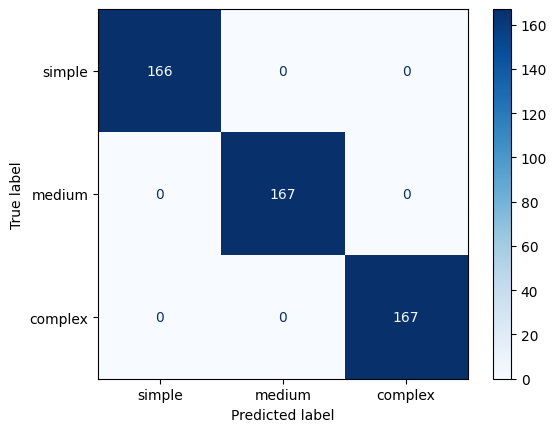

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_dataset["label"], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label2id.keys())
disp.plot(cmap="Blues")
plt.show()


In [ ]:
# ✅ STEP 1: Install dependencies (if not already installed)
!pip install -q transformers torch onnx onnxruntime onnxruntime-tools

# ✅ STEP 2: Load fine-tuned model
from transformers import BertForSequenceClassification, BertTokenizer
import torch

model_path = "./bert-complexity/checkpoint-564"  #
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# ✅ STEP 3: Prepare dummy input
inputs = tokenizer("Set a timer for 5 minutes", return_tensors="pt", padding="max_length", truncation=True, max_length=64)

# ✅ STEP 4: Export to ONNX (FP32)
torch.onnx.export(
    model,
    (inputs["input_ids"], inputs["attention_mask"]),
    "bert_complexity_fp32.onnx",
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "seq_len"},
        "attention_mask": {0: "batch_size", 1: "seq_len"},
        "logits": {0: "batch_size"}
    },
    opset_version=14
)
print("✅ Exported to bert_complexity_fp32.onnx")

# ✅ STEP 5: Quantize to INT8 (optional but faster)
from onnxruntime.quantization import quantize_dynamic, QuantType
quantize_dynamic(
    model_input="bert_complexity_fp32.onnx",
    model_output="bert_complexity_int8.onnx",
    weight_type=QuantType.QInt8
)
print("✅ Quantized to bert_complexity_int8.onnx")

# ✅ STEP 6: Download ONNX files (if in Colab)
from google.colab import files
files.download("bert_complexity_fp32.onnx")
files.download("bert_complexity_int8.onnx")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

✅ Quantized to bert_complexity_int8.onnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>